<a href="https://colab.research.google.com/github/cch98/2019_CS470_Colab/blob/master/6_Try_and_test_your_own_network_on_Fashion_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try and test your own network on Fashion-MNIST dataset
====

## Instruction
- Go to step 5 to build blocks of your own network.
- Train & test the network to see how good your model is.
- You can refer to [this notebook](https://drive.google.com/open?id=1oO1cVmR_fyQFaIydRtYAs62StaQRJjEM) for stacking dropout and batch normalization layers
- You can also try some hyper-parameter tunings (in step 3), such as trimming the learning rate, batch_size, etc.


## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 2: Import modules

In [2]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST

# import TensorBoardColab
!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [3]:
# training & optimization hyper-parameters
max_epoch = 200
learning_rate = 0.0001
batch_size = 20
device = 'cuda'

# model hyper-parameters
input_dim = 784 # 28x28=784
hidden_dim = 512
output_dim = 10 

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://17dc2c3f.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.MNIST`** will automatically construct **`MNIST`** dataset.

In [0]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.ToTensor()

# train_dataset = MNIST(data_dir, train=True, download=True, transform=transform)
train_dataset = FMNIST(data_dir, train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# test_dataset = MNIST(data_dir, train=False, download=True, transform=transform)
test_dataset = FMNIST(data_dir, train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Step 5: Construct a neural network builder

In [0]:
class MyClassifier(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=512, output_dim=10):
    super(MyClassifier, self).__init__()
    self.layers = nn.Sequential(
      # .. stack your layers here ...
        nn.Conv2d(1, 20, 3, 1, 1),
        nn.LeakyReLU(),
        nn.Conv2d(20, 20, 3, 1, 1),
        nn.LeakyReLU(),
        nn.Conv2d(20, 10, 4, 2, 1),
        nn.LeakyReLU(),
        nn.Conv2d(10, 10, 4, 2, 1),
        nn.LeakyReLU(),
    )
    self.layer2 = nn.Sequential(
        nn.Linear(490, 100),
        nn.LeakyReLU(),
        nn.Linear(100, 10),
        
    )
    
  def forward(self, x):
    batch_size = x.size(0)
#     x = x.view(batch_size, -1)
    x = self.layers(x)
    x = x.view(batch_size, -1)
    x = self.layer2(x)
    return x

## Step 6: Initialize the network and optimizer

In [0]:
my_classifier = MyClassifier(input_dim, hidden_dim, output_dim)
my_classifier = my_classifier.to(device)

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


## Step 7: Load pre-trained weights if exist

In [14]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.91


## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [13]:

it = 0
train_losses = []
test_losses = []
for epoch in range(max_epoch):
  # train phase
  my_classifier.train()
  for inputs, labels in train_dataloader:
    it += 1
    
    # load data to the GPU.
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # feed data into the network and get outputs.
    logits = my_classifier(inputs)
    
    # calculate loss
    # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
    loss = F.cross_entropy(logits, labels)
    
    # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
    #       Otherwise, gradients will accumulate.
    optimizer.zero_grad()
    
    # backprogate loss.
    loss.backward()
    
    # update the weights in the network.
    optimizer.step()
    
    # calculate accuracy.
    acc = (logits.argmax(dim=1) == labels).float().mean()
    
    if it % 200 == 0:
      tbc.save_value('Loss', 'train_loss', it, loss.item())
      print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))
    
  # save losses in a list so that we can visualize them later.
  train_losses.append(loss.item())  
    
  # test phase
  n = 0.
  test_loss = 0.
  test_acc = 0.
  my_classifier.eval()
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)
    
    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum')
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum()
    n += inputs.size(0)
    
  test_loss /= n
  test_acc /= n
  test_losses.append(test_loss.item())
  tbc.save_value('Loss', 'test_loss', it, test_loss.item())
  print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss.item(), test_acc.item())) 
  
  tbc.flush_line('train_loss')
  tbc.flush_line('test_loss')
  
  # save checkpoint whenever there is improvement in performance
  if test_acc > best_acc:
    best_acc = test_acc
    # Note: optimizer also has states ! don't forget to save them as well.
    ckpt = {'my_classifier':my_classifier.state_dict(),
            'optimizer':optimizer.state_dict(),
            'best_acc':best_acc}
    torch.save(ckpt, ckpt_path)
    print('checkpoint is saved !')
    
tbc.close()

[epoch:0, iteration:200] train loss : 1.5562 train accuracy : 0.5000
[epoch:0, iteration:400] train loss : 0.6203 train accuracy : 0.7500
[epoch:0, iteration:600] train loss : 1.0956 train accuracy : 0.7500
[epoch:0, iteration:800] train loss : 0.6181 train accuracy : 0.7000
[epoch:0, iteration:1000] train loss : 0.3144 train accuracy : 0.9500
[epoch:0, iteration:1200] train loss : 0.5978 train accuracy : 0.7000
[epoch:0, iteration:1400] train loss : 0.3838 train accuracy : 0.8000
[epoch:0, iteration:1600] train loss : 0.6799 train accuracy : 0.8500
[epoch:0, iteration:1800] train loss : 0.3789 train accuracy : 0.8000
[epoch:0, iteration:2000] train loss : 0.5979 train accuracy : 0.7000
[epoch:0, iteration:2200] train loss : 0.4427 train accuracy : 0.8500
[epoch:0, iteration:2400] train loss : 0.3729 train accuracy : 0.9500
[epoch:0, iteration:2600] train loss : 0.4241 train accuracy : 0.9000
[epoch:0, iteration:2800] train loss : 0.4794 train accuracy : 0.8000
[epoch:0, iteration:3000

KeyboardInterrupt: ignored

## Step 9: Visualize and analyze the results

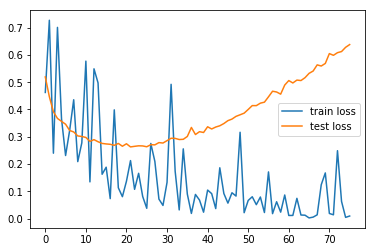

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

label : 4
prediction : 2


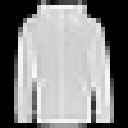

In [25]:
import random
from PIL import Image

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

topil = transforms.transforms.ToPILImage()
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %i' % test_label)
print('prediction : %i' % test_prediction)

test_image = topil(test_input)
test_image.resize((128, 128))